In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload
from time import time
import pickle
import re

import numpy as np
import scipy as sc
from sklearn.isotonic import IsotonicRegression
from scipy.integrate import quad_vec
import pandas as pd
import torch
print(torch.cuda.is_available())

import models
import dre
import rna
import vae
import designers
import utils

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('whitegrid')

True


2024-12-18 00:52:19.289829: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-18 00:52:19.289860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-18 00:52:19.291031: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 00:52:19.297702: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-18 00:52:21.012766: W tensorflow/comp

In [2]:
# load training, calibration, and models
noise_sd = 0.02
p_mut = 4 / 50
n_hidden = 100
n_filters = 32

# load training data
data_fname = '/homefs/home/wongfanc/density-ratio-estimation/rna-models/traindata-nsd0.02-040324.npz'
d = np.load(data_fname)
trainseq_n = list(d['trainseq_n'])
ytrain_n = d['ytrain_n']
print(f'Loaded {ytrain_n.size} training points from {data_fname}.\n')

# train ridge regression 
ridge = ridge = models.RidgeRegressor(seq_len=50, alphabet=rna.RNA_NUCLEOTIDES)
ridge.fit(trainseq_n, ytrain_n)

# load trained FF and CNN models
model_and_data_path = '/homefs/home/wongfanc/density-ratio-estimation/rna-models'
model_and_data_fname_no_ftype = 'nsd0.02-040324'

ff_fname = os.path.join(model_and_data_path, 'ff-' + model_and_data_fname_no_ftype + '.pt')
ff = models.FeedForward(50, rna.RNA_NUCLEOTIDES, n_hidden)
ff.load(ff_fname)

cnn_fname = os.path.join(model_and_data_path, 'cnn-' + model_and_data_fname_no_ftype + '.pt')
cnn = models.CNN(50, rna.RNA_NUCLEOTIDES, n_filters, n_hidden)
cnn.load(cnn_fname)

name2model = {
    'ridge': ridge,
    'ff': ff,
    'cnn': cnn
}

Loaded 5000 training points from /homefs/home/wongfanc/density-ratio-estimation/rna-models/traindata-nsd0.02-040324.npz.



# IR calibration with unweighted calibration data

adalead-ff-0.2 50000 0.38242927
adalead-ff-0.15 50000 0.39103
adalead-ff-0.1 50000 0.39983925
adalead-ff-0.05 50000 0.41670227
adalead-ff-0.01 50000 0.41358665
biswas-ff-0.02 50000 0.33376792
biswas-ff-0.015 50000 0.34536034
biswas-ff-0.01 50000 0.3617079
biswas-ff-0.005 50000 0.38015595
pex-ff 50000 0.34006613
cbas-ff-0.1 50000 0.28751266
cbas-ff-0.2 50000 0.289747
cbas-ff-0.3 50000 0.29041022
cbas-ff-0.4 50000 0.28889275
cbas-ff-0.5 50000 0.28960758
cbas-ff-0.6 50000 0.2899109
cbas-ff-0.7 50000 0.2908237
cbas-ff-0.8 50000 0.29221186
cbas-ff-0.9 50000 0.2937097
dbas-ff-0.1 50000 0.31099495
dbas-ff-0.2 50000 0.31314635
dbas-ff-0.3 50000 0.31557468
dbas-ff-0.4 50000 0.32271188
dbas-ff-0.5 50000 0.33649594
dbas-ff-0.6 50000 0.3423706
dbas-ff-0.7 50000 0.35253605
dbas-ff-0.8 50000 0.34581888
dbas-ff-0.9 50000 0.34994128


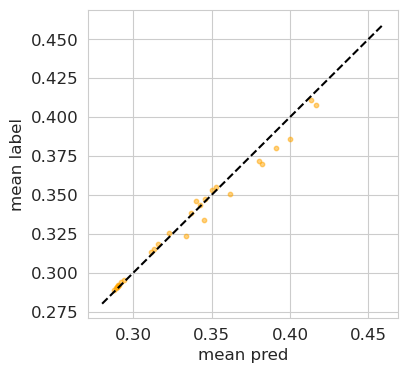

In [4]:
# load designs
design_pkl_fname = '/data/wongfanc/rna-results/designs-041124.pkl'
adalead_thresholds = [0.2, 0.15, 0.1, 0.05, 0.01]
biswas_temperatures = [0.02, 0.015, 0.01, 0.005]
cbas_dbas_quantiles = np.arange(0.1, 0.91, 0.1)
dbas_ridge_quantiles = [0.1, 0.2]

design_names = [] # ['vae-ridge']
# # cbas ridge
# for q in cbas_dbas_quantiles:
#     q = round(q, 2)
#     design_names.append(f'cbas-ridge-{q}t19')

# # dbas ridge
# for q in dbas_ridge_quantiles:
#     q = round(q, 2)
#     design_names.append(f'dbas-ridge-{q}t19')
    
for model_name in ['ff']:  # ['ridge', 'ff', 'cnn']:
    
    # adalead
    for thresh in adalead_thresholds:
        thresh = round(thresh, 4)
        design_names.append(f'adalead-{model_name}-{thresh}')
    
    # biswas
    for temp in biswas_temperatures:
        temp = round(temp, 4)
        design_names.append(f'biswas-{model_name}-{temp}') 
    
    # PEX
    design_names.append(f'pex-{model_name}') 
        
    if model_name != 'ridge':
        # cbas
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            design_names.append(f'cbas-{model_name}-{q}')
        
        # dbas
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            design_names.append(f'dbas-{model_name}-{q}')

# load all designs, including intermediate CbAS/DbAS iterations, etc.
with open(design_pkl_fname, 'rb') as f:
    name2designdata_all = pickle.load(f)

# extract the configurations on the menu
name2designdata = {name: name2designdata_all[name] for name in design_names}
# name2designdata['train'] = (trainseq_n, ytrain_n, None)

# plot mean prediction vs. mean label
plt.figure(figsize=(4, 4))
name2color = {
    'ridge': 'steelblue',
    'ff': 'orange',
    'cnn': 'green'
}
for name, data in name2designdata.items():
    print(name, len(data[0]), np.mean(data[2]) if name != 'train' else None)
    if name != 'train':
        for n, color in name2color.items():
            if n in name:
                break
        plt.scatter(np.mean(data[2]), np.mean(data[1]), s=10, c=color, alpha=0.5)
        
plt.xlabel('mean pred'); plt.ylabel('mean label');
plt.plot([0.28, 0.46], [0.28, 0.46], '--k');

In [3]:
# load calibration data
cal_trial_idx = 100
cal_data_fname = '/data/wongfanc/rna-data/calibration-pm0.08-nsd0.02_041524_2.pkl'

with open(cal_data_fname, 'rb') as f:
    caldata_t = pickle.load(f)
calseqs_n, ycal_n = caldata_t[cal_trial_idx]

In [6]:
calpred_nxm = ff.ensemble_predict(calseqs_n)
calmu_n = np.mean(calpred_nxm, axis=1)
calstd_n = np.std(calpred_nxm, axis=1)

data = np.hstack([calmu_n[:, None], calstd_n[:, None], ycal_n[:, None]])
df = pd.DataFrame(data, columns=['mu', 'sigma', 'y'])
df.to_csv(f'../jiwon-121724/calibration.csv')

In [7]:
n_forecast_designs = 1000

for design_name in design_names:
    (designseq_N, _, designpred_n) = name2designdata[design_name]

    designpred_nxm = ff.ensemble_predict(designseq_N)
    designmu_n = np.mean(designpred_nxm, axis=1)
    assert(np.max(np.abs(designmu_n - designpred_n)) < 1e-16)
    designstd_n = np.std(designpred_nxm, axis=1)
    
    forecast_idx = np.random.choice(len(designseq_N), size=n_forecast_designs, replace=False)
    data = np.hstack([designmu_n[forecast_idx, None], designstd_n[forecast_idx, None]])
    df = pd.DataFrame(data, columns=['mu', 'sigma'])
    df.to_csv(f'../jiwon-121724/{design_name}_designs.csv')
    print(design_name)

adalead-ff-0.2
adalead-ff-0.15
adalead-ff-0.1
adalead-ff-0.05
adalead-ff-0.01
biswas-ff-0.02
biswas-ff-0.015
biswas-ff-0.01
biswas-ff-0.005
pex-ff
cbas-ff-0.1
cbas-ff-0.2
cbas-ff-0.3
cbas-ff-0.4
cbas-ff-0.5
cbas-ff-0.6
cbas-ff-0.7
cbas-ff-0.8
cbas-ff-0.9
dbas-ff-0.1
dbas-ff-0.2
dbas-ff-0.3
dbas-ff-0.4
dbas-ff-0.5
dbas-ff-0.6
dbas-ff-0.7
dbas-ff-0.8
dbas-ff-0.9


In [14]:
# calibrate ridge PPDs
# HERE: how is this already perfectly calibrated?

model = name2model['ridge']
calmu_n = model.predict(calseqs_n)
calF_n = np.array([sc.stats.norm.cdf(y, loc=mu, scale=np.sqrt(model.mse)) for y, mu in zip(ycal_n, calmu_n)])
calempF_n = np.mean(calF_n[:, None] <= calF_n[None, :], axis=0, keepdims=False)

# ir = IsotonicRegression(y_min=0, y_max=1)
# ir.fit(calF_n, calempF_n)
# calcalF_n = ir.predict(calF_n) 

# plot
# plt.figure(figsize=(3, 3))
# plt.scatter(calF_n, calcalF_n, s=1, alpha=0.5);
# plt.plot([0, 1], [0, 1], '--k')
# plt.xlabel('original CDF');
# plt.ylabel('calibrated CDF');

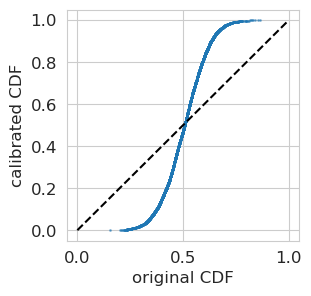

In [53]:
# calibrate forecasts

# get predictions
model = name2model['ff']
predcal_nxm = model.ensemble_predict(calseqs_n)
calmu_n = np.mean(predcal_nxm, axis=1)
calsigma_n = np.std(predcal_nxm, axis=1)

# get forecasts
calF_n = np.array([sc.stats.norm.cdf(y, loc=mu, scale=sig) for y, mu, sig in zip(ycal_n, calmu_n, calsigma_n)])
calempF_n = np.mean(calF_n[:, None] <= calF_n[None, :], axis=0, keepdims=False)

# calibrate forecasts
ir = IsotonicRegression(y_min=0, y_max=1, out_of_bounds='clip')
ir.fit(calF_n, calempF_n)
calcalF_n = ir.predict(calF_n) 

# plot
plt.figure(figsize=(3, 3))
plt.scatter(calF_n, calcalF_n, s=1, alpha=0.5);
plt.plot([0, 1], [0, 1], '--k')
plt.xlabel('original CDF');
plt.ylabel('calibrated CDF');

In [51]:
# get designs from configuration
name = 'adalead-ff-0.2'
designseq_n, ydesign_n, preddesign_n = name2designdata[name]

def calibrated_cdf(y, predmu, predsigma, ir):
    F = sc.stats.norm.cdf(y, loc=predmu, scale=predsigma)
    calF_1 = ir.predict(np.array([F]))
    return calF_1[0]

def calibrated_cdf_vec(y, predmu_n, predsigma_n, ir):
    F_n = sc.stats.norm.cdf(y, loc=predmu_n, scale=predsigma_n)
    calF_n = ir.predict(F_n)
    return calF_n

# get design predictions
t0 = time()
preddesign_nxm = model.ensemble_predict(designseq_n)

# get design PPDs
predmu_n = np.mean(preddesign_nxm, axis=1)
predsigma_n = np.std(preddesign_nxm, axis=1)

# get calibrated design PPDs and integrate to compute E[Y|x] for each design
term1_n, term1_max_err = quad_vec(
    lambda y: 1 - calibrated_cdf_vec(y, predmu_n, predsigma_n, ir),
    0, 0.6,
    limit=200,
    norm='max'
    # workers=-1,
)
# assume 2nd term is 0
# term2_n, term2_err_n = quad_vec(
#     lambda y: calibrated_cdf_vec(y, predmu_n, predsigma_n, ir),
#     -0.5, 0,
#     limit=100,
#     # workers=-1,
# )
print(term1_max_err)
meanydesign_n = term1_n #  - term2_n
print('{} sec'.format(time() - t0))


0.0014427568343890395
51.103601694107056 sec


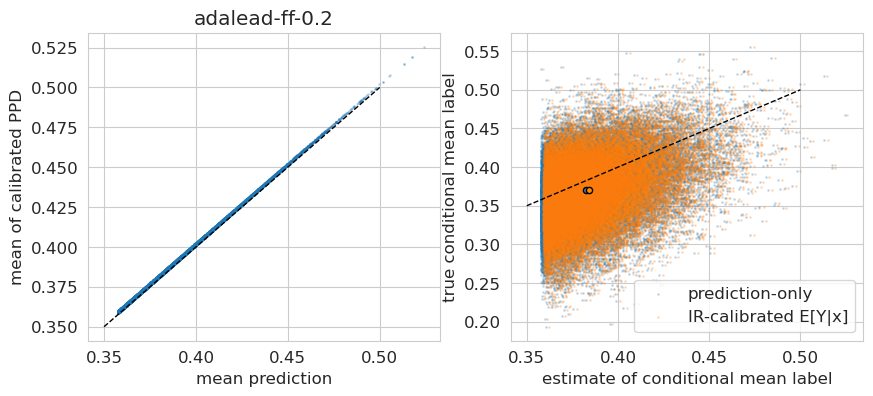

In [52]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.scatter(preddesign_n, meanydesign_n, s=1, alpha=0.2)
plt.plot([0.35, 0.5], [0.35, 0.5], '--k', linewidth=1)
plt.xlabel('mean prediction');
plt.ylabel('mean of calibrated PPD');
plt.title(name);

plt.subplot(122)
plt.scatter(preddesign_n, ydesign_n, s=1, alpha=0.2, label='prediction-only')
plt.scatter(meanydesign_n, ydesign_n, s=1, alpha=0.2, label='IR-calibrated E[Y|x]')
plt.scatter(np.mean(preddesign_n), np.mean(ydesign_n), c='steelblue', s=20, linewidths=1, edgecolor='k')
plt.scatter(np.mean(meanydesign_n), np.mean(ydesign_n), s=20, c='darkorange', linewidths=1, edgecolor='k')
plt.plot([0.35, 0.5], [0.35, 0.5], '--k', linewidth=1)
plt.legend()
plt.xlabel('estimate of conditional mean label');
plt.ylabel('true conditional mean label');


In [28]:
# sanity checking
reload(utils)
predmu_n = np.array([0.01, 1, -0.5])
predsigma_n = np.array([0.01, 0.2, 2])
positive_int_limits = (0, 5)
negative_int_limits =  (-5, 0)

class Identity():
    def __init__(self):
        pass
    def predict(self, f):
        return f

identity = Identity()
m_n = utils.get_mean_from_cdf(
    predmu_n,
    predsigma_n,
    identity, # maps CDF value to calibrated CDF value
    positive_int_limits,
    negative_int_limits,
    quad_limit=200,
    err_norm='max'
)
print(m_n)


[ 0.01        1.         -0.49332925]


# IR calibration with weighted calibration data

adalead-ff-0.2 50000 0.38242927
adalead-ff-0.1 50000 0.39983925
adalead-ff-0.05 50000 0.41670227
adalead-ff-0.01 50000 0.41358665
adalead-ff-0.15 50000 0.39103
train 5000 None


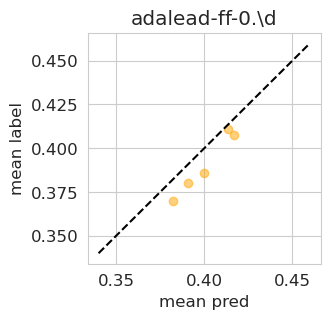

In [3]:
design_pkl_fname = '/data/wongfanc/rna-results/designs-041124.pkl'
model_name = 'ff'
regex_str = 'adalead-{}-0.\d'.format(model_name)
regex = re.compile(regex_str)

with open(design_pkl_fname, 'rb') as f:
    name2designdata_all = pickle.load(f)
    
name2designdata = {
    name: data for name, data in name2designdata_all.items()
    if regex.match(name) is not None and
    '0.5' not in name and '0.45' not in name and
    '0.4' not in name and '0.35' not in name and
    '0.3' not in name and '0.25' not in name
}
name2designdata['train'] = (trainseq_n, ytrain_n, None)

# plot
name2color = {
    'ridge': 'steelblue',
    'ff': 'orange',
    'cnn': 'green'
}
plt.figure(figsize=(3, 3))
for name, data in name2designdata.items():
    print(name, len(data[0]), np.mean(data[2]) if name != 'train' else None)
    if name != 'train':
        for n, color in name2color.items():
            if n in name:
                break
        plt.scatter(np.mean(data[2]), np.mean(data[1]), c=color, alpha=0.5)
plt.xlabel('mean pred'); plt.ylabel('mean label');
plt.plot([0.34, 0.46], [0.34, 0.46], '--k');
plt.title(regex_str);

In [4]:
# DRE
reload(dre)

quadratic_final_layer = True
n_hidden = 128
n_epoch = 100
lr = 1e-3
device = torch.device('cuda')

mdre_group_regex_strs = [
    'adalead-ff-0.\d',
]

mdre = dre.MultiMDRE(
    mdre_group_regex_strs,
    device=device
)
mdre.fit(
    list(name2designdata.keys()),
    name2designdata,
    quadratic_final_layer=quadratic_final_layer,
    lr=lr,
    n_hidden=n_hidden,
    n_epoch=n_epoch,
    verbose=True
)
loss_df = mdre.idx2lossdf[0]


Fitting MDRE for adalead-ff-0.\d, which has 5 design algorithms:
train
adalead-ff-0.2
adalead-ff-0.1
adalead-ff-0.05
adalead-ff-0.01
adalead-ff-0.15
One-hot-encoding all 6 categories of sequences...
  Done. (3 s)


100%|████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.94it/s]

Min train loss 0.66, min val loss 0.62



In [5]:
# load calibration data
cal_trial_idx = 2
cal_data_fname = '/data/wongfanc/rna-data/calibration-pm0.08-nsd0.02_041524_2.pkl'

with open(cal_data_fname, 'rb') as f:
    caldata_t = pickle.load(f)
calseqs_n, ycal_n = caldata_t[cal_trial_idx]

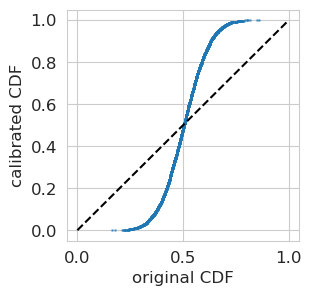

In [6]:
# calibrate PPDs
model = name2model['ff']
design_name = 'adalead-ff-0.15'

# get predictions
predcal_nxm = model.ensemble_predict(calseqs_n)
calmu_n = np.mean(predcal_nxm, axis=1)
calsigma_n = np.std(predcal_nxm, axis=1)

# get PPDs
calF_n = np.array([sc.stats.norm.cdf(y, loc=mu, scale=sig) for y, mu, sig in zip(ycal_n, calmu_n, calsigma_n)])
calempF_n = np.mean(calF_n[:, None] <= calF_n[None, :], axis=0, keepdims=False)

# get weights
caldr_n = mdre.get_dr(calseqs_n, design_name, self_normalize=True)

# calibrate PPDs
ir = IsotonicRegression(y_min=0, y_max=1, out_of_bounds='clip')
ir.fit(calF_n, calempF_n, sample_weight=caldr_n)
calcalF_n = ir.predict(calF_n) 

# plot
plt.figure(figsize=(3, 3))
plt.scatter(calF_n, calcalF_n, s=1, alpha=0.5);
plt.plot([0, 1], [0, 1], '--k')
plt.xlabel('original CDF');
plt.ylabel('calibrated CDF');

In [7]:
# get designs from configuration
designseq_n, ydesign_n, preddesign_n = name2designdata[design_name]

def calibrated_cdf_vec(y, predmu_n, predsigma_n, ir):
    F_n = sc.stats.norm.cdf(y, loc=predmu_n, scale=predsigma_n)
    calF_n = ir.predict(F_n)
    return calF_n

# get design predictions
t0 = time()
preddesign_nxm = model.ensemble_predict(designseq_n)

# get design PPDs
predmu_n = np.mean(preddesign_nxm, axis=1)
predsigma_n = np.std(preddesign_nxm, axis=1)

# get calibrated design PPDs and integrate to compute E[Y|x] for each design
term1_n, term1_max_err = quad_vec(
    lambda y: 1 - calibrated_cdf_vec(y, predmu_n, predsigma_n, ir),
    0, 0.6,
    limit=200,
    norm='max'
)
print(term1_max_err)
meanydesign_n = term1_n
print('{} sec'.format(time() - t0))


0.001405001359698637
51.08090138435364 sec


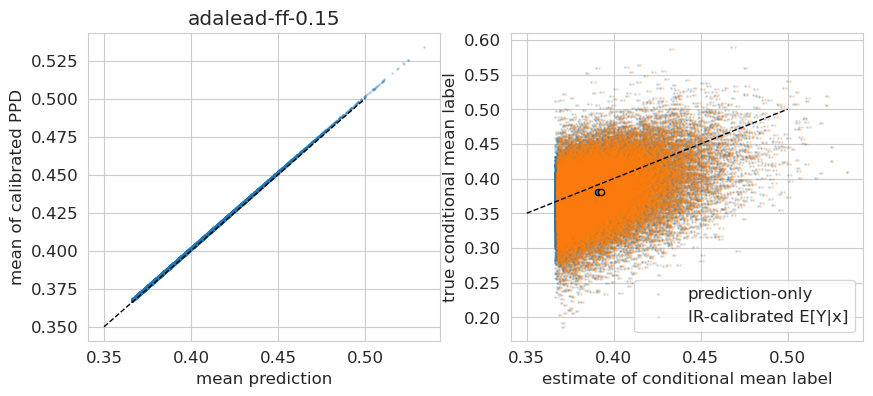

In [8]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.scatter(preddesign_n, meanydesign_n, s=1, alpha=0.2)
plt.plot([0.35, 0.5], [0.35, 0.5], '--k', linewidth=1)
plt.xlabel('mean prediction');
plt.ylabel('mean of calibrated PPD');
plt.title(design_name);

plt.subplot(122)
plt.scatter(preddesign_n, ydesign_n, s=1, alpha=0.2, label='prediction-only')
plt.scatter(meanydesign_n, ydesign_n, s=1, alpha=0.2, label='IR-calibrated E[Y|x]')
plt.scatter(np.mean(preddesign_n), np.mean(ydesign_n), c='steelblue', s=20, linewidths=1, edgecolor='k')
plt.scatter(np.mean(meanydesign_n), np.mean(ydesign_n), s=20, c='darkorange', linewidths=1, edgecolor='k')
plt.plot([0.35, 0.5], [0.35, 0.5], '--k', linewidth=1)
plt.legend()
plt.xlabel('estimate of conditional mean label');
plt.ylabel('true conditional mean label');
